In [81]:
from scipy import *
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

# Actuated walking ball VR
## what needs to be achieved?
+ instantaneous force added to the force exerted by the mouse's foot push
+ System mechanical properties that need to be countered: friction of the system, rotational inertia of the ball

## how?
very high speed closed loop: as soon as the mouse exerts a minute force, the compensatory force needs to be added as instantaneously as possible
+ requirements
    + sampling of the balls angular acceleration and speed
    + calculation of the compensatory motor command
    + moving motors

## Implementation ideas
### balance bot problems
The fully internal balance bot will have the disadvantage of needing to get the motors and the power in the ball (= unnecessary weight). This problem can be solved by splitting the balancing bot into 2 parts: one with the motion sensort inside sitting on passive wheels, transmitting balance bot position to the outside where the ball sits on actuators that drive the sphere, balancing the bot inside.

The classic balance bot features a PID control loop with upward direction as the setpoint (The actuated sphere is different, because the balance bot is in an instable equilibrium, whereas the supported sphere is not, this should make things much easier). However, 2D PID control will cover translational movements, but not rotations. In order for the mouse to feel that turning is equal to walking/backward/sideways, they need to be "supported" i.e. "measure current torque applied by mouse and add torque to ball by motors". If this scheme is applied to one degree of freedom, we should apply it to all 3 - this will simplify things greatly (explained below).

I also think that having a moveable element inside the ball that measures the direction of gravity has two disadvantages: a) There are now two coupled inertia elements, the ball and the balanced sensor. Each foot push by the mouse first has to move the ball, which then has to move the rolling structure inside.I think that this coupled system of two inertial elements will be much harder to control than keeping it simpler.

Additionally, the balance bot scheme has another problem: Balance bots minimize use the PID control loop to minimize the angle between upright and actual angle ($\phi$). What we actually need for supported movements is $\ddot\phi$, as when the mouse exerts a force, we want to add some compensatory force. For example, in the limit of a very very heavy ball, the mouse will not be able to cause any angular deflection of the ball, hence the compensatory circuit will never output any supporting movement.

### Holonomic drive variant
I suggest a different approach, in which the force of the mouse acting on the ball is measured directly and translated to supporting motor commands:
+ The sphere is hollow and has an IMU attatched somewhere at the wall. This IMU is connected to an arduino/bluetooth transmitter and a battery.
+ Sphere sits on 4 omniwheels, connected to actuating motors
+ outside microcontroller acting as data reciever, calculating the supporting motor commands, applying them to the motors
![overview](overview.jpg)


## Parts
### IMU
This one https://yostlabs.com/3-space-sensors/ looks quite good. It seems fast, precise and inexpensive, if we run into precision problems (I think we might) we can add multiple into the ball and try sensor averaging.

Alternatively, 3 torquemeters can be used to probe each torque axis
http://www.scaime.com/en/165/produit/rotating-torquemeter-contactless-bare-shaft-speed-30-000trmn.html

### Omniwheels
4 Wheels over 3 (as most ball balance bots or holonomic drives seem to feature) because 3 should have a worse friction distribution across the angle of translation.
A collection of omniwheels: http://www.nexusrobot.com/product/product-category/omni-wheels

those look best http://www.nexusrobot.com/product/127mm-heavy-duty-aluminum-omni-wheel-bearing-rollers-central-bearing-14146.html (fully round, always a touching wheel)

### Data receiver / motor command calculator
Fast arduino based microcontroller, teensy 3.6: 180Mhz https://www.pjrc.com/teensy/
TODO teensy is 32bit, check if compatibility with arduino is "full" (including all necessary libraries)

PWM tech details
https://www.precisionmicrodrives.com/tech-blog/2016/09/21/encoder-resolution-ppr-and-cpr


### Sphere
2 hemispheres, one with tongue, one with groove, removeable small service window (for battery charger plug)
TODO check https://www.wecutfoam.com/ if they can do it 

probably yes https://www.wecutfoam.com/wecutfoam-coating-composites?lightbox=image1rb

they also offer coatings (TODO check grip)


## System specs estimation
### mouse capabilities
Maximal running speed of a mouse according to http://www.speedofanimals.com/animals/house_mouse is 13 km/h = 3.6 m/s. In my experiments, top speed was 0.5 m/s. I assume that it takes a mouse a half second to reach top speed from standin still

In [82]:
#vmax = 13000/3600 # [m/s]
vmax = 0.5
amax = vmax / 0.5 # [m/s**2]

# mouse max force 
m_mouse = 0.03 # [kg]
F_mouse = m_mouse * amax


### Sphere specs
system specs (actuators etc) will depend much on the ball specs.
I assume now: 
+ radius 30cm, 
+ wall thickness 5cm
+ polystyrene density $\rho=28 - 45 kg/m^{3}$ (https://en.wikipedia.org/wiki/Polystyrene#Extruded_polystyrene_foam)

In [83]:
def Vsphere(r):
    return 4/3*pi*r**3
r = 0.3 # [m]
rho = 45 # [kg/m**3]
V = Vsphere(0.30)-Vsphere(0.25)
m = V * rho # [kg]
# m = 11

Hollow sphere inertia:
$I = 2/5  m  \frac{r_{a}^{5}-r_{i}^{5}}{r_{a}^{3}-r_{i}^{3}}$


In [84]:
def Isphere(ra,ri,m):
    return 2/5 * m * (ra**5-ri**5)/(ra**3-ri**3)
I = Isphere(0.3,0.25,m) # [kg*m**2]
I

0.1095866057388459

Find "missing" torque: compare angular acceleration when the mouse runs (with its full force) on the ball to the anfular acceleration it would have if it runs on a circular path

$\alpha$ being the angular acceleration, $\omega$ the angular velocity ($2\pi/T$)

$M = I \alpha = F_{mouse} r$ 


In [85]:
# mouse on circular path
U = 2*pi*r
T = U/vmax
w = 2*pi/T # [rad/s]
alpha_ideal = w/0.5 # [rad/s**2] , as divide by half second to reach topspeed

# torque on the ball generated by the mouse -> get angular accel
# M = r * F
# M = I * alpha # [Nm]
alpha_real = r * F_mouse / I

# missing torque
M_sphere = (alpha_ideal-alpha_real)*I

# torque transmission from small motor to sphere? gear ratio torque amplification
# Forces at contact point must be equal -> M1/r1 = M2/r2
r_wheel = 0.127/2 # omniwheel diameter
M_motor = M_sphere * r_wheel / r
# also think about the inertia of the wheel
M_motor # [Nm]

0.07541443849351906

"Worst case" scenario, this torque has to be generated by two motors alone (Worst case is a common case: mouse runs straight forward)
So: Motor choice has to have a max torque output of at least $M/2$

In [86]:
M_motor/2 # [Nm]

0.03770721924675953

Motor selection:
excess power: https://www.faulhaber.com/fileadmin/Import/Media/EN_MCS3274_BP4_RSCO_DFF.pdf

this could be enough already https://www.faulhaber.com/de/produkte/serie/3153brc/


<IPython.core.display.Javascript object>


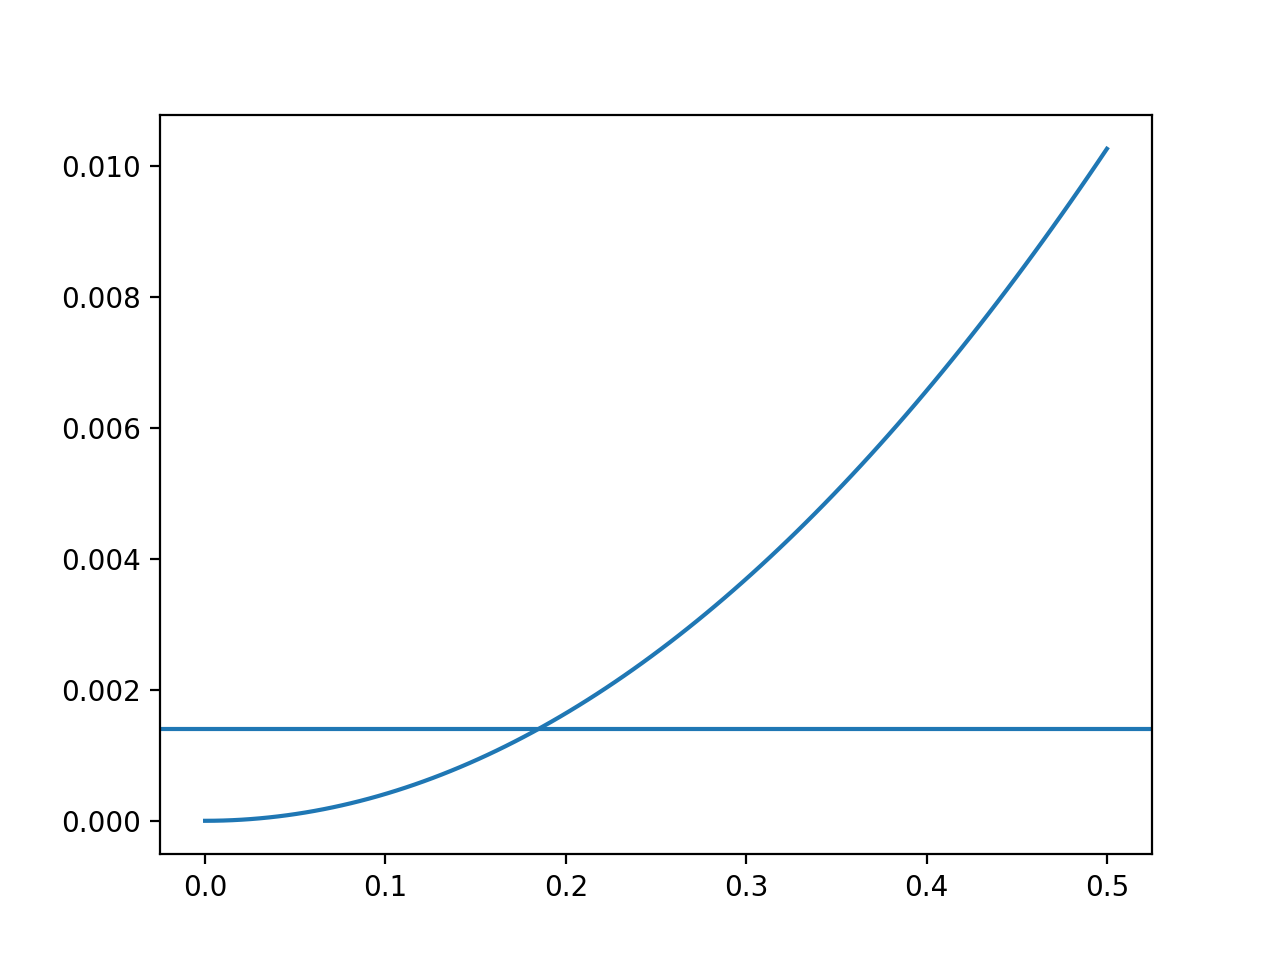

In [87]:
# another consideration: for non torque measureing schemes, what is the time that the mouse needs to exert
# max force until change  can be detected by IMU?
IMU_res = 0.08 # deg
# phi = 1/2 * alpha * t**2 - analogous to allgemeine bewegungsgleichung
t = linspace(0,0.5,100)
phi = 0.5*alpha_real*t**2
plt.plot(t,phi)
plt.axhline(IMU_res*(2*pi)/360)
plt.show()

## Implementation details
### reading sensor
during loop, receive data from IMU: angular acceleration of current yaw, pitch, roll angles $\ddot\phi$

yost labs IMU comes with a C library for retrieving those ()

(TODO ask if it compiles on Arduino based systems)

#### obtaining $\ddot\phi$
Problem: if the IMU is not perfectly in the center of the sphere, $\ddot\phi$ will be a superposition of the IMUs rotation and the translation (on a circular path) depending on the current $\phi$. This needs to be corrected for:

carthesian conversion: rotation matrix
https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions#Conversion_formulae_between_formalisms

computationally much faster (much fewer trigonometry calls):
conversion to polar coordinates, rotate, convert back to carthesian
https://en.wikipedia.org/wiki/Spherical_coordinate_system#Coordinate_system_conversions
(easy)

TODO bluetooth/wireless communication between two arduino (http://www.martyncurrey.com/connecting-2-arduinos-by-bluetooth-using-a-hc-05-and-a-hc-06-pair-bind-and-link/)
### calculating motor commands
#### system friction compensation
friction is proportional to $\dot{\phi}$, so each loop, add $F_{f}=K_{1}\dot{\phi}$ to motors, $K_{1}$ with unit $[kg/s]$
#### Sphere inertia compensation
same as friction, but inertia proportional to $\ddot{\phi}$, so $F_{I} = K_{2}\ddot{\phi}$ added to motors, $K_{2}$ with unit $[kg]$

#### Force composition
No problem for holonomic drive commands are easily composable (see above) $F_{total} = F_{f} + F_{I}$, see below

### sending motor commands
Arduino libraries for sending PWM commands driving brushless motors. TODO check if the arduinos `Servo.h` library is compatible with the faulhaber motor.

#### K tuning
Here, another advantage of the holonomic drive variant over the ball balance bot: Balance bot requires tuning of PID which is a dark art. Here we just
1. with $K_{2}=0$ increase $K_{1}$ until system is instable and starts to accelerate by it's own
2. lower $K_{1}$ just below this critical value (=almost frictionless)
3. increase $K_{2}$ until system is smooth and can be moved with tiny forces

## Motor command calculation
Idea follows a holonomic drive: adapted from this video (https://www.youtube.com/watch?v=ULQLD6VvXio) to a 4 wheel variant, converted from 2d plus torque along rotational axis to pitch,roll,yaw torque

### motor force decomposition
<img src="holonomic.jpg" width="600">


and then the for all 4 motors

$$M_{p} = -\sum_{i}|F_{i}|r'_{i}cos(\pi/2-\alpha_{i})$$
$$M_{r} = \sum_{i}|F_{i}|r'_{i}sin(\pi/2-\alpha_{i})$$
$$M_{y} = \sum_{i}r'_{i}|F_{i}|$$

with $F_{i}$ being the force of motor $i$ and it's angle $\alpha$ with respect to $x$, $M$ is the torque and $r'$ the motors distance from $(0,0)$. These translate to the spheres pitch, roll and yaw, respectively.

Note that $r'\neq r$: $|r'|=|r|sin(\pi/4)$ for 45 deg down


Command forces converted to motor output powers are obtained by matrix inversion
<img src="motor.jpg" width="800">

note: Matrix inversion calculated numerically after the specs are set and then hardcoded as numbers to the teensy.

<IPython.core.display.Javascript object>


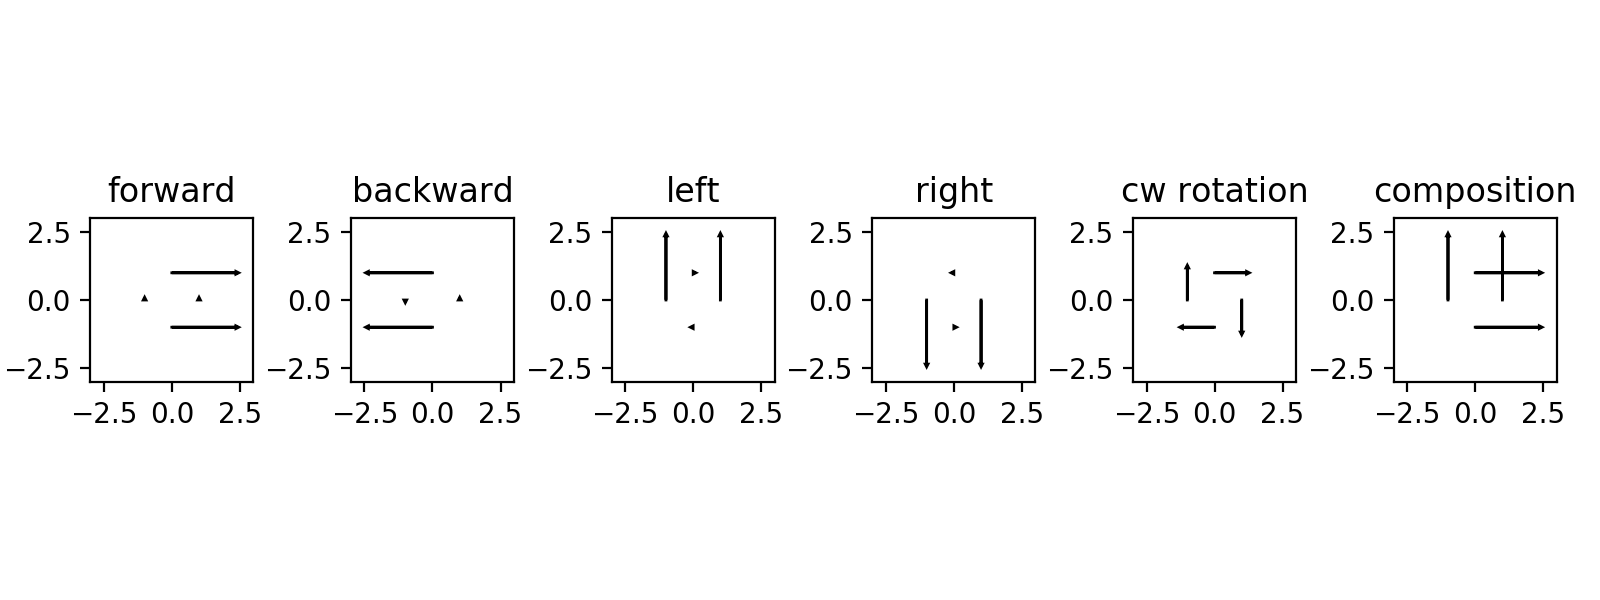

In [88]:
from scipy import linalg
alphas = array([0,90,180,270]) * (2*pi/360) # motor layout, all aligned to axis, +x is forward
rp = r*sin(pi/4)
Mp = -cos(pi/2-alphas)*rp
Mr = sin(pi/2-alphas)*rp
My = ones(4)*rp
L = stack([Mp,Mr,My])
Li = linalg.pinv(L) # numerical pseudo inverse of L

# to get (f1,f2,f3,f4) vector  Li*(Mp,Mr,My)

# for plotting purposes
motor_pos = array(((1,0),(0,1),(-1,0),(0,-1)))
f_unity = array(((0,1),(-1,0),(0,-1),(1,0)))

# movements
moves = {'forward':    array([ 1, 0, 0])[:,newaxis],
         'backward':   array([-1, 0, 0])[:,newaxis],
         'left':       array([ 0, 1, 0])[:,newaxis],
         'right':      array([ 0,-1, 0])[:,newaxis],
         'cw rotation':array([ 0, 0,-1])[:,newaxis]}

moves['composition'] = moves['forward'] + moves['left']
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig, axes = plt.subplots(ncols=len(moves),figsize=[8,3])
for i,(name,move) in enumerate(moves.items()):
    axes[i].set_title(name)
    fs = dot(Li,move) # the conversion
    for j,v in enumerate(fs * f_unity):
        axes[i].arrow(motor_pos[j][0],motor_pos[j][1],v[0],v[1],head_width=0.1, head_length=0.1)
        
for ax in axes:
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.set_aspect('equal')
fig.tight_layout()

and conversion to torque:

Need a function that maps requested torque to motor output torque based on input PWM freq ... and thats it! 

## Anticipated problems
+ traction between omni wheels and styrofoam surface probably bad - rubber coating?
+ precision of wecutfoam / similar producer
+ IMU sensor data not precise enough
    + use multiple IMUs, sensor averaging?
+ IMU not suitable for our task as it measures accel (and not force)
    + rotary torque sensors? https://www.sensors.co.uk/files/dsm/Datasheet_E200-ORT.pdf
    

## leftovers / links
+ sliding ball drive (omniwheel alternative?) https://www.youtube.com/watch?v=HbKvtivAx8A
+ 

mNm rotarty torque sensor https://www.sensors.co.uk/files/dsm/Datasheet_E200-ORT.pdf
yost lab IMU capabilities: 
0.00024*9.81